In [1]:
import datetime
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datlib.FRED import *
from datlib.plots import *
import pandas_datareader.data as web

%matplotlib inline

# Import Statsmodels

from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [2]:
#FRED.py
#. . . 
def bil_to_mil(series):
    return series* 10**3
# . . .
#fedProject.py
# . . .
data_codes  = {# Assets
               "Balance Sheet: Total Assets ($ Mil)": "WALCL",
               "Balance Sheet Securities, Prem-Disc, Repos, and Loans ($ Mil)": "WSRLL",
               "Balance Sheet: Securities Held Outright ($ Mil)": "WSHOSHO",
               ### breakdown of securities holdings ###
               "Balance Sheet: U.S. Treasuries Held Outright ($ Mil)":"WSHOTSL",
               "Balance Sheet: Federal Agency Debt Securities ($ Mil)" : "WSHOFADSL",
               "Balance Sheet: Mortgage-Backed Securities ($ Mil)": "WSHOMCB",
               # other forms of lending
               "Balance Sheet: Repos ($ Mil)": "WORAL",
               "Balance Sheet: Central Bank Liquidity Swaps ($ Mil)" : "SWPT",
               "Balance Sheet: Direct Lending ($ Mil)" : "WLCFLL",
               # unamortized value of securities held (due to changes in interest rates)
               "Balance Sheet: Unamortized Security Premiums ($ Mil)": "WUPSHO",
               # Liabilities
               "Balance Sheet: Total Liabilities ($ Mil)" : "WLTLECL",
               "Balance Sheet: Federal Reserve Notes Outstanding ($ Mil)" : "WLFN",
               "Balance Sheet: Reverse Repos ($ Mil)": "WLRRAL",
               ### Major share of deposits 
               "Balance Sheet: Deposits from Dep. Institutions ($ Mil)":"WLODLL",
               "Balance Sheet: U.S. Treasury General Account ($ Mil)": "WDTGAL",
               "Balance Sheet: Other Deposits ($ Mil)": "WOTHLB",
               "Balance Sheet: All Deposits ($ Mil)": "WLDLCL",
               # Capital
               "Balance Sheet: Total Capital": "WCTCL",
               # Interest Rates
               "Unemployment Rate": "UNRATE",
               "Nominal GDP ($ Bil)":"GDP",
               "Real GDP ($ Bil)":"GDPC1",
               "GDP Deflator":"GDPDEF",
               "CPI":"CPIAUCSL",
               "Core PCE":"PCEPILFE",
               "Private Investment":"GPDI",
               "Base: Total ($ Mil)": "BOGMBASE",
               "Base: Currency in Circulation ($ Bil)": "WCURCIR",
               "1 Month Treasury Rate (%)": "DGS1MO",
               "3 Month Treasury Rate (%)": "DGS3MO",               
               "1 Year Treasury Rate (%)": "DGS1",
               "2 Year Treasury Rate (%)": "DGS2",
               "10 Year Treasury Rate (%)": "DGS10",
               "30 Year Treasury Rate (%)": "DGS30",               
               "Effective Federal Funds Rate (%)": "DFF",
               "Federal Funds Target Rate (Pre-crisis)":"DFEDTAR",
               "Federal Funds Upper Target":"DFEDTARU",
               "Federal Funds Lower Target":"DFEDTARL",
               "Interest on Reserves (%)": "IOER",
               "VIX": "VIXCLS",
                "5 Year Forward Rate": "T5YIFR"
               }

inflation_target = 2

unemployment_target = 4
# Select start and end dates
start = datetime.datetime(2000, 1, 1)
end = datetime.datetime.today()

## year variable automatically adjusts the numper of periods  
#   per year in light of data frequency
annual_div = {"Q":4,
             "W":52,
             "M":12}
### choose frequency
freq = "M"
### set periods per year
year = annual_div[freq]


## TWICE DIFF WITH MONTHLY RATE: M4 TA FFR CC NGDP 

In [3]:
#data cleaning, importing

d_parser = lambda x: pd.datetime.strptime(x, '%m/%d/%Y')
df = pd.read_csv('M4-11.csv', parse_dates=['Date'], date_parser=d_parser)
df

C:\Users\PROMA~1.GUP\AppData\Local\Temp/ipykernel_10400/2192722440.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  d_parser = lambda x: pd.datetime.strptime(x, '%m/%d/%Y')


,Date,Log M4 including Treasuries,Log Total Assets,Effective Federal Funds Rate (%),Log Currency in Circulation ($ Bil),Log Nominal GDP (Bln),Unemployment Rate,Inflation Rate
0,2010-01-31,7.07,14.63,0.11,6.83,16.51,9.8,2.62
1,2010-02-28,7.06,14.63,0.13,6.83,16.70,9.8,2.15
2,2010-03-31,7.05,14.65,0.17,6.84,16.70,9.9,2.29
3,2010-04-30,7.06,14.66,0.20,6.84,16.52,9.9,2.21
4,2010-05-31,7.06,14.66,0.20,6.84,16.70,9.6,2.00
...,...,...,...,...,...,...,...,...
115,2019-08-31,7.40,15.14,2.13,7.47,16.70,3.7,1.74
116,2019-09-30,7.40,15.15,2.04,7.47,16.70,3.5,1.72
117,2019-10-31,7.41,15.19,1.83,7.48,16.89,3.6,1.77
118,2019-11-30,7.42,15.21,1.55,7.49,16.70,3.6,2.04


In [4]:
df['Date_at_year_month'] = df['Date'].dt.strftime('%Y-%m')
column_names = {'Date_at_year_month':'DATE',
                'Log M4 including Treasuries':'M4',
                'Log Total Assets': 'TA',
                'Log Currency in Circulation ($ Bil)':'CC',
                'Log Nominal GDP (Bln)':'NGDP',
               'Effective Federal Funds Rate (%)': 'FFR',
               'Unemployment Rate': 'U',
               'Inflation Rate': 'I'}


# rename columns
df = df.rename(columns = column_names)
df = df.set_index('DATE')
df = df.drop(['Date'], axis = 1)
df = df.drop(['U','I'], axis = 1)
df

,M4,TA,FFR,CC,NGDP
DATE,,,,,
2010-01,7.07,14.63,0.11,6.83,16.51
2010-02,7.06,14.63,0.13,6.83,16.70
2010-03,7.05,14.65,0.17,6.84,16.70
2010-04,7.06,14.66,0.20,6.84,16.52
2010-05,7.06,14.66,0.20,6.84,16.70
...,...,...,...,...,...
2019-08,7.40,15.14,2.13,7.47,16.70
2019-09,7.40,15.15,2.04,7.47,16.70
2019-10,7.41,15.19,1.83,7.48,16.89


In [5]:
df_new = df.diff().dropna()

In [6]:
df = df_new.diff().dropna()
df

,M4,TA,FFR,CC,NGDP
DATE,,,,,
2010-03,8.881784e-16,2.000000e-02,0.02,1.000000e-02,-0.19
2010-04,2.000000e-02,-1.000000e-02,-0.01,-1.000000e-02,-0.18
2010-05,-1.000000e-02,-1.000000e-02,-0.03,0.000000e+00,0.36
2010-06,-1.000000e-02,1.000000e-02,-0.02,1.000000e-02,-0.18
2010-07,2.000000e-02,-2.000000e-02,0.02,-1.000000e-02,-0.17
...,...,...,...,...,...
2019-08,1.000000e-02,0.000000e+00,-0.29,-1.000000e-02,-0.36
2019-09,-1.000000e-02,2.000000e-02,0.18,0.000000e+00,0.18
2019-10,1.000000e-02,3.000000e-02,-0.12,1.000000e-02,0.19


In [16]:
df.to_csv("MA-NGDP-M.csv")

In [7]:
#ADF test

X = df["M4"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")
    
    
X = df["FFR"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")
    
    
X = df["TA"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")
    
    
X = df["CC"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")
    
    
X = df["NGDP"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")

ADF Statistic: -8.381034
p-value: 0.000000
Critical Values:
	1%: -3.491
	5%: -2.888
	10%: -2.581
Reject Ho - Time Series is Stationary
ADF Statistic: -3.943879
p-value: 0.001735
Critical Values:
	1%: -3.492
	5%: -2.889
	10%: -2.581
Reject Ho - Time Series is Stationary
ADF Statistic: -6.016185
p-value: 0.000000
Critical Values:
	1%: -3.490
	5%: -2.887
	10%: -2.581
Reject Ho - Time Series is Stationary
ADF Statistic: -6.497273
p-value: 0.000000
Critical Values:
	1%: -3.494
	5%: -2.889
	10%: -2.582
Reject Ho - Time Series is Stationary
ADF Statistic: -9.041977
p-value: 0.000000
Critical Values:
	1%: -3.492
	5%: -2.889
	10%: -2.581
Reject Ho - Time Series is Stationary


In [8]:
## Partial Correlation

import statsmodels.api as sm

residuals = {}
for y_var in df.keys():
    X_vars = list(df.keys())
    X_vars.remove(y_var)
    X = df[X_vars]
    # Initial estimate should include constant
    #   This won't be the case we regress the errors
    X["Constant"] = 1
    # pass y_var as list for consistent structure
    y = df[[y_var]]
    model = sm.OLS(y, X)
    results = model.fit()
    residuals[y_var] = results.resid
residuals = pd.DataFrame(residuals)
residuals

,M4,TA,FFR,CC,NGDP
DATE,,,,,
2010-03,0.002266,0.021385,0.073781,0.007450,-0.251514
2010-04,0.015494,-0.004844,0.039686,-0.005667,-0.114575
2010-05,-0.008633,-0.016333,-0.120451,-0.000121,0.399718
2010-06,-0.009484,0.009980,0.016095,0.005844,-0.193220
2010-07,0.015675,-0.014680,0.063929,-0.003976,-0.110353
...,...,...,...,...,...
2019-08,-0.003003,0.003953,-0.211302,-0.014544,-0.049576
2019-09,-0.002151,0.018271,0.137866,-0.000313,-0.071530
2019-10,0.012304,0.025590,-0.129247,0.007236,0.265340


In [9]:
residuals.corr()[residuals.corr().abs() < 1].mul(-1).fillna(1).round(2)

,M4,TA,FFR,CC,NGDP
M4,1.00,-0.08,-0.18,-0.20,-0.12
TA,-0.08,1.00,-0.06,0.12,0.19
FFR,-0.18,-0.06,1.00,-0.12,0.46
CC,-0.20,0.12,-0.12,1.00,-0.05
NGDP,-0.12,0.19,0.46,-0.05,1.00


In [10]:
# !pip install pingouin
import pingouin
df.pcorr().round(2)

,M4,TA,FFR,CC,NGDP
M4,1.00,-0.08,-0.18,-0.20,-0.12
TA,-0.08,1.00,-0.06,0.12,0.19
FFR,-0.18,-0.06,1.00,-0.12,0.46
CC,-0.20,0.12,-0.12,1.00,-0.05
NGDP,-0.12,0.19,0.46,-0.05,1.00


In [11]:
pcorr_pvalues = {}
for y, Y in residuals.items():
    pcorr_pvalues[y] = {}
    for x, X in residuals.items():
        if x != y:
            pcorr_pvalues[y][x] = sm.OLS(Y,X).fit().pvalues[x]
        
        else:
            pcorr_pvalues[y][x] = np.NaN
pd.DataFrame(pcorr_pvalues).round(2)

,M4,TA,FFR,CC,NGDP
M4,NaN,0.39,0.05,0.03,0.19
TA,0.39,NaN,0.51,0.20,0.04
FFR,0.05,0.51,NaN,0.21,0.00
CC,0.03,0.20,0.21,NaN,0.57
NGDP,0.19,0.04,0.00,0.57,NaN


In [12]:
residuals

,M4,TA,FFR,CC,NGDP
DATE,,,,,
2010-03,0.002266,0.021385,0.073781,0.007450,-0.251514
2010-04,0.015494,-0.004844,0.039686,-0.005667,-0.114575
2010-05,-0.008633,-0.016333,-0.120451,-0.000121,0.399718
2010-06,-0.009484,0.009980,0.016095,0.005844,-0.193220
2010-07,0.015675,-0.014680,0.063929,-0.003976,-0.110353
...,...,...,...,...,...
2019-08,-0.003003,0.003953,-0.211302,-0.014544,-0.049576
2019-09,-0.002151,0.018271,0.137866,-0.000313,-0.071530
2019-10,0.012304,0.025590,-0.129247,0.007236,0.265340


In [13]:
##DAG

import pingouin
from pgmpy.estimators import PC
import matplotlib.pyplot as plt
from matplotlib.patches import ArrowStyle
from networkx.drawing.nx_agraph import graphviz_layout
import warnings
warnings.filterwarnings("ignore")
from matplotlib.backends.backend_pdf import PdfPages
import networkx as nx

C:\Users\proma.gupta\Anaconda3\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.0, the latest is 0.5.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [14]:
## Estimating a Directed Acyclic Graph
p_val = .01
from pgmpy.estimators import PC
c = PC(df)
max_cond_vars = len(df.keys())-2


model = c.estimate(return_type = "pdag",variant= "parallel",#"orig", "stable"
                   significance_level = p_val, 
                   max_cond_vars = max_cond_vars, ci_test = "pearsonr")
edges = model.edges()

  0%|          | 0/3 [00:00<?, ?it/s]

AttributeError: module 'matplotlib.cbook' has no attribute 'iterable'

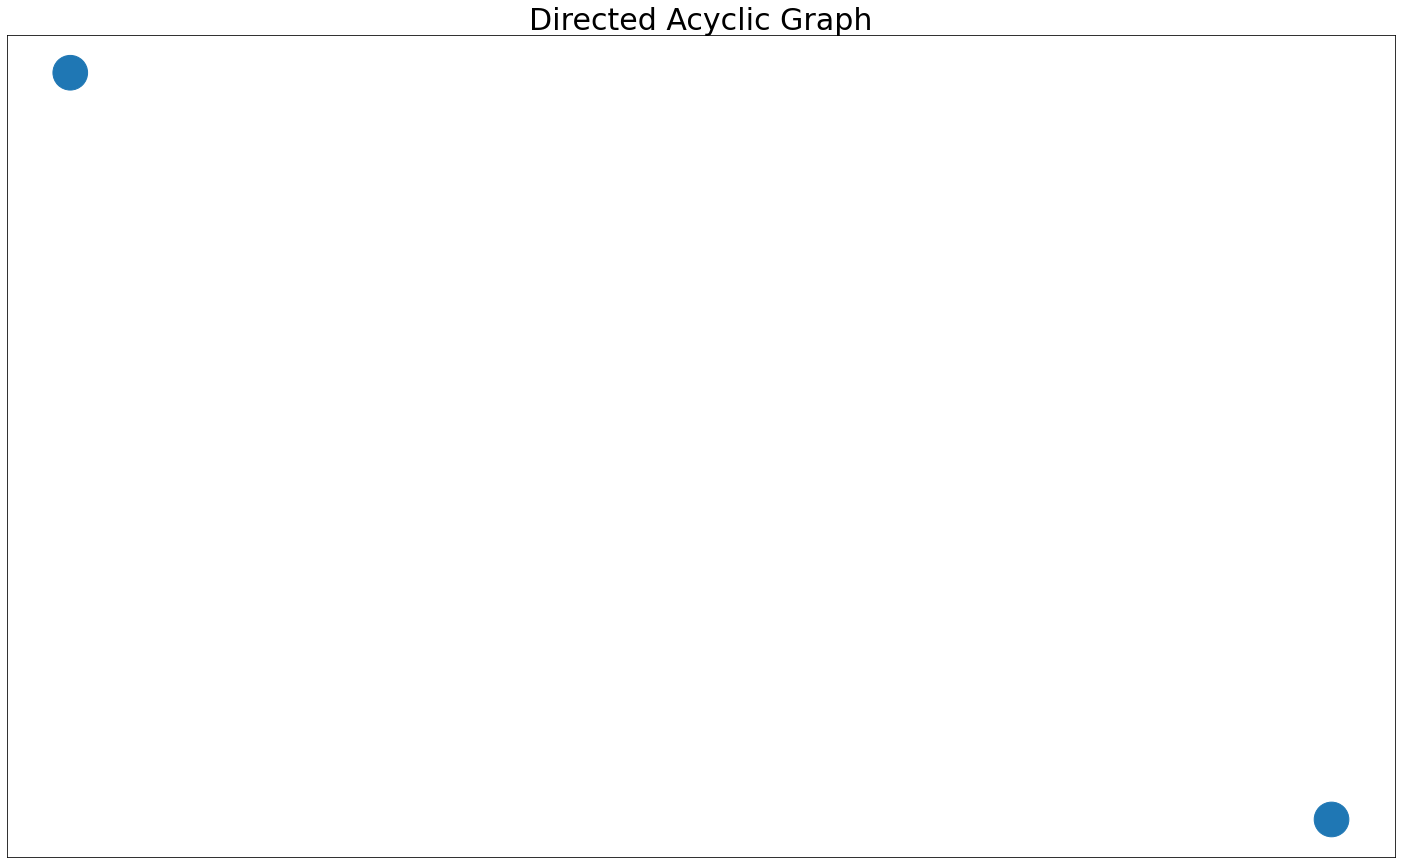

In [15]:
from matplotlib.patches import ArrowStyle

def graph_DAG(edges, df, title = ""):
    graph = nx.DiGraph()
    graph.add_edges_from(edges)
    color_map = ["C0" for g in graph]

    fig, ax = plt.subplots(figsize = (20,12))
    graph.nodes()
    plt.tight_layout()
    pos = nx.spring_layout(graph)#, k = 5/(len(sig_corr.keys())**.5))

    plt.title(title, fontsize = 30)
    nx.draw_networkx(graph, pos, node_color=color_map, node_size = 1200,
                     with_labels=True,  arrows=True,
                     font_color = "white",
                     font_size = 26, alpha = 1,
                     width = 1, edge_color = "C1",
                     arrowstyle=ArrowStyle("Fancy, head_length=3, head_width=1.5, tail_width=.1"), ax = ax)

graph_DAG(edges, df, title = "Directed Acyclic Graph")
edges

In [ ]:
## D-separation

def graph_DAG(edges, df, title = ""):
    graph = nx.DiGraph()
    edge_labels = {}
    ############ Add ############
    for edge in edges:
        controls = [key for key in df.keys() if key not in edge]
        controls = list(set(controls))
        keep_controls = []
        for control in controls:
            control_edges = [ctrl_edge for ctrl_edge in edges if control == ctrl_edge[0] ]
            if (control, edge[1]) in control_edges:
                print("keep control:", control)
                keep_controls.append(control)                
        print(edge, keep_controls)
        pcorr = df[[edge[0], edge[1]]+keep_controls].pcorr()
#         corr_matrix_heatmap(pcorr, save_fig = False, pp = None, title = "Partial Correlation")
        edge_labels[edge] = str(round(pcorr[edge[0]].loc[edge[1]],2))
    graph.add_edges_from(edges)
    color_map = ["C0" for g in graph]

    fig, ax = plt.subplots(figsize = (20,12))
    graph.nodes()
    plt.tight_layout()
    pos = nx.spring_layout(graph)#, k = 5/(len(sig_corr.keys())**.5))

    plt.title(title, fontsize = 30)
    nx.draw_networkx(graph, pos, node_color=color_map, node_size = 1200,
                     with_labels=True,  arrows=True,
                     # turn text black for larger variable names in homework
                     font_color = "k",
                     font_size = 26, alpha = 1,
                     width = 1, edge_color = "C1",
                     arrowstyle=ArrowStyle("Fancy, head_length=3, head_width=1.5, tail_width=.1"), ax = ax)
    ############ Add ############
    nx.draw_networkx_edge_labels(graph,pos,
                                edge_labels=edge_labels,
                                font_color='green',
                                font_size=20)

graph_DAG(edges, df, title = "Directed Acyclic Graph")

In [ ]:
data = df
def firstLetterWord(str, num_chars = 3):
 
    result = ""
 
    # Traverse the string.
    v = True
    for i in range(len(str)):
         
        # If it is space, set v as true.
        if (str[i] == ' '):
            v = True
 
        # Else check if v is true or not.
        # If true, copy character in output
        # string and set v as false.
        elif (str[i] != ' ' and v == True):
            result += (str[i:i+num_chars])
            v = False
 
    return result

In [ ]:
def graph_DAG(edges, data_reg, title = "", 
              fig = False, ax = False, 
              edge_labels = False,sig_vals = [0.05, 0.01, 0.001]):
    pcorr = data_reg.pcorr()
    graph = nx.DiGraph()
    def build_edge_labels(edges, df, sig_vals):
        edge_labels = {}
        for edge in edges:
            controls = [key for key in df.keys() if key not in edge]
            controls = list(set(controls))
            keep_controls = []
            for control in controls:
                control_edges = [ctrl_edge for ctrl_edge in edges if control == ctrl_edge[0] ]
                if (control, edge[1]) in control_edges:
                    keep_controls.append(control)                
#             print(edge, keep_controls)
            pcorr = df.partial_corr(x = edge[0], y = edge[1], covar=keep_controls,
                                  method = "pearson")
            label = str(round(pcorr["r"][0],2))
            pvalue = pcorr["p-val"][0]
#             pcorr = df[[edge[0], edge[1]]+keep_controls].pcorr()
#             label = pcorr[edge[0]].loc[edge[1]]

            for sig_val in sig_vals:
                if pvalue < sig_val: 
                    label = label + "*"   
            
            edge_labels[edge] = label
        return edge_labels
    
    if edge_labels == False:
        edge_labels = build_edge_labels(edges, 
                                        data_reg, 
                                        sig_vals=sig_vals) 
    graph.add_edges_from(edges)
    color_map = ["grey" for g in graph]

    if fig == False and ax == False: fig, ax = plt.subplots(figsize = (20,12))
    graph.nodes()
    plt.tight_layout()
    #pos = nx.spring_layout(graph)
    pos = graphviz_layout(graph)

    edge_labels2 = []
    for u, v, d in graph.edges(data=True):
        if pos[u][0] > pos[v][0]:  
            if (v,u) in edge_labels.keys():
                edge_labels2.append(((u, v,), f'{edge_labels[u,v]}\n\n\n{edge_labels[(v,u)]}'))  
        if (v,u) not in edge_labels.keys():
            edge_labels2.append(((u,v,), f'{edge_labels[(u,v)]}'))
    edge_labels = dict(edge_labels2)

    nx.draw_networkx(graph, pos, node_color=color_map, node_size = 2500,
                     with_labels=True,  arrows=True,
                     font_color = "black",
                     font_size = 26, alpha = 1,
                     width = 1, edge_color = "C1",
                     arrowstyle=ArrowStyle("Fancy, head_length=3, head_width=1.5, tail_width=.1"),
                     connectionstyle='arc3, rad = 0.05',
                     ax = a)
    nx.draw_networkx_edge_labels(graph,pos,
                                 edge_labels=edge_labels,
                                 font_color='green',
                                 font_size=20,
                                ax = a)
    

DAG_models_vars = {0:["M4","TA", "NGDP"],
                  1:["TA", "CC", "FFR"],
                  2:["M4","CC", "FFR"],
                  3:["TA", "CC", "FFR", "M4"],
                  4:["TA", "NGDP", "FFR", "CC","M4"],
                  5:["CC", "NGDP","M4"]}
# link_sigs = [0.05, 0.1, 0.2]
link_sigs = [0.05, .1, .2]
algorithms = ["orig", "stable", "parallel"]
for keys in DAG_models_vars.values():
    fig, ax = plt.subplots(len(algorithms), len(link_sigs), figsize = (30,30))
    max_cond_vars = len(keys) - 2
    data_reg = data[keys].dropna()
    data_reg.rename(columns = {col:firstLetterWord(col) for col in keys}, inplace = True)
    keys = data_reg.keys()
    c = PC(data_reg[keys].dropna())
    max_cond_vars = len(keys) - 2
    i,j = 0,0
    for sig in link_sigs:
        for algorithm in algorithms:
            model = c.estimate(return_type = "pdag", variant = algorithm, 
                               significance_level = sig, 
                               max_cond_vars = max_cond_vars, ci_test = "pearsonr")
            edges = model.edges()
            pcorr = data_reg.pcorr()
            weights = {}
            a = ax[i][j]
            graph_DAG(edges, data_reg, fig = fig, ax = a)
        
            if j == 0:
                a.set_ylabel(algorithm, fontsize = 20)
            if i == len(algorithms) - 1:
                a.set_xlabel("$p \leq$ "+ str(sig), fontsize = 20)
            i += 1
        j += 1
        i = 0
    plt.suptitle(str(list(keys)).replace("[","").replace("]",""), fontsize = 40, y =1.035)
    plt.show()
    plt.close()
edges

## TWICE DIFF WITH YEARLY RATE: M4 TA FFR CC NGDP

In [38]:
#data cleaning, importing

d_parser = lambda x: pd.datetime.strptime(x, '%m/%d/%Y')
df = pd.read_csv('M4-11.csv', parse_dates=['Date'], date_parser=d_parser)
df

,Date,Log M4 including Treasuries,Log Total Assets,Effective Federal Funds Rate (%),Log Currency in Circulation ($ Bil),Log Nominal GDP (Bln),Unemployment Rate,Inflation Rate
0,2010-01-31,7.07,14.63,0.11,6.83,16.51,9.8,2.62
1,2010-02-28,7.06,14.63,0.13,6.83,16.70,9.8,2.15
2,2010-03-31,7.05,14.65,0.17,6.84,16.70,9.9,2.29
3,2010-04-30,7.06,14.66,0.20,6.84,16.52,9.9,2.21
4,2010-05-31,7.06,14.66,0.20,6.84,16.70,9.6,2.00
...,...,...,...,...,...,...,...,...
115,2019-08-31,7.40,15.14,2.13,7.47,16.70,3.7,1.74
116,2019-09-30,7.40,15.15,2.04,7.47,16.70,3.5,1.72
117,2019-10-31,7.41,15.19,1.83,7.48,16.89,3.6,1.77
118,2019-11-30,7.42,15.21,1.55,7.49,16.70,3.6,2.04


In [39]:
df['Date_at_year_month'] = df['Date'].dt.strftime('%Y-%m')
column_names = {'Date_at_year_month':'DATE',
                'Log M4 including Treasuries':'M4',
                'Log Total Assets': 'TA',
                'Log Currency in Circulation ($ Bil)':'CC',
                'Log Nominal GDP (Bln)':'NGDP',
               'Effective Federal Funds Rate (%)': 'FFR',
               'Unemployment Rate': 'U',
               'Inflation Rate': 'I'}


# rename columns
df = df.rename(columns = column_names)
df = df.set_index('DATE')
df = df.drop(['Date'], axis = 1)
df = df.drop(['U','I'], axis = 1)
df

,M4,TA,FFR,CC,NGDP
DATE,,,,,
2010-01,7.07,14.63,0.11,6.83,16.51
2010-02,7.06,14.63,0.13,6.83,16.70
2010-03,7.05,14.65,0.17,6.84,16.70
2010-04,7.06,14.66,0.20,6.84,16.52
2010-05,7.06,14.66,0.20,6.84,16.70
...,...,...,...,...,...
2019-08,7.40,15.14,2.13,7.47,16.70
2019-09,7.40,15.15,2.04,7.47,16.70
2019-10,7.41,15.19,1.83,7.48,16.89


In [40]:
df_new = df.diff(year).dropna()

In [ ]:
#ADF test

X = df_new["M4"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")
    
    
X = df_new["FFR"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")
    
    
X = df_new["TA"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")
    
    
X = df_new["CC"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")
    
    
X = df_new["NGDP"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")

In [41]:
df = df_new.diff(year).dropna()
df

,M4,TA,FFR,CC,NGDP
DATE,,,,,
2012-01,2.000000e-02,0.10,-0.15,0.03,0.000000e+00
2012-02,1.000000e-02,0.06,-0.09,0.03,0.000000e+00
2012-03,-8.881784e-16,-0.01,0.02,0.02,0.000000e+00
2012-04,-8.881784e-16,-0.07,0.14,0.00,3.552714e-15
2012-05,-2.000000e-02,-0.13,0.18,0.01,0.000000e+00
...,...,...,...,...,...
2019-08,8.881784e-16,-0.07,-0.55,-0.01,0.000000e+00
2019-09,1.000000e-02,-0.04,-0.73,-0.03,0.000000e+00
2019-10,2.000000e-02,0.02,-1.40,-0.01,-3.552714e-15


In [42]:
data = df

In [46]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
import statsmodels.api as sm
import copy
import pingouin
from scipy.stats import pearsonr
from datlib.ts_tests import *
from statsmodels.tsa.adfvalues import *
import warnings
warnings.simplefilter("ignore")
import statsmodels
statsmodels.__file__

'C:\\Users\\proma.gupta\\Anaconda3\\lib\\site-packages\\statsmodels\\__init__.py'

In [21]:
df.to_csv("MA-NGDP-Y-MAIN.csv")

$FFR$ 8.388960700189782e-21
$CC$ 0.0
$M4$ 0.0
$TA$ 0.0
$NGDP$ 0.0
$FFR$ 8.388960700189782e-21
$CC$ 0.0
$M4$ 0.0
$TA$ 0.0
$NGDP$ 0.0
$FFR$ 4.150050685964075e-11
$CC$ 0.0
$M4$ 0.0
$TA$ 0.0
$NGDP$ 0.0


ValueError: The number of FixedLocator locations (1), usually from a call to set_ticks, does not match the number of ticklabels (3).

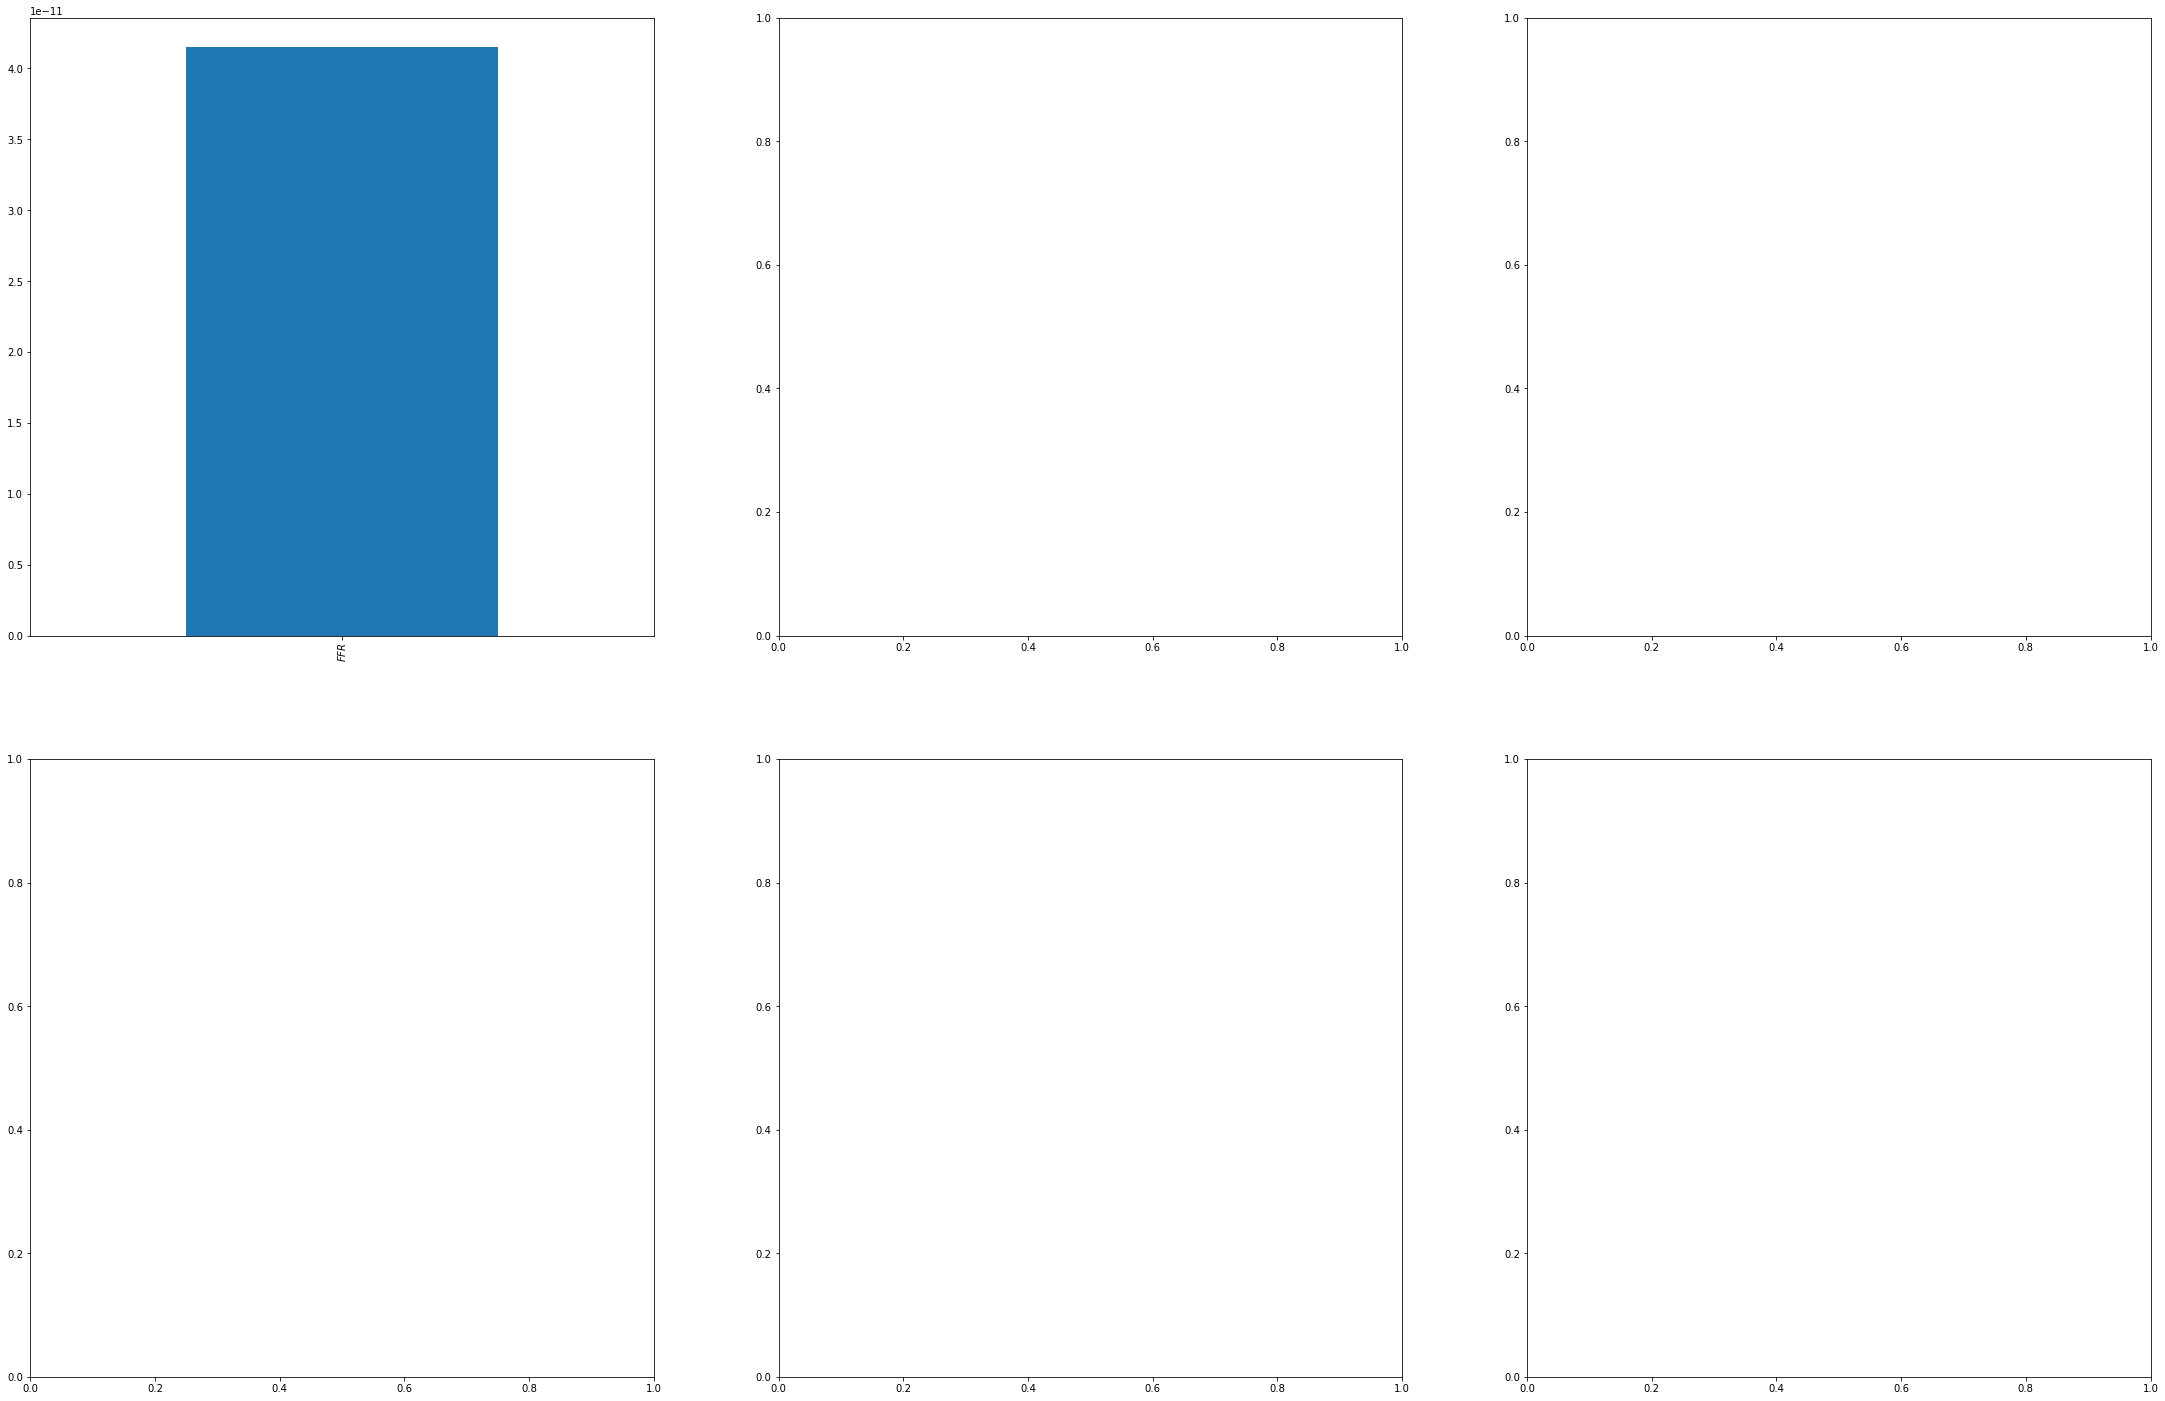

In [49]:
def dickey_fuller(data, 
                  key, 
                  lags = 1, 
                  annual_lags = True, 
                  time_trend = False, 
                  constant = True):
    lag_length = lags * year if annual_lags else lags
    test_data = data.copy()
    lag_freq = year if annual_lags else 1 
    test_data[key + " Diff"] = test_data[key].diff(lag_freq)
    lag_var = key + " Lag"
    test_data[lag_var] = test_data[key].shift(lag_freq)
    test_data[key + " Lag Diff"] = test_data[key].diff(lag_freq).shift(lag_freq)
    test_data.dropna(inplace = True)
    y = test_data[[key]]# + " Diff"]]
    X = test_data[[lag_var, key + " Lag Diff"]]
    regression = ""
    if constant:
        X["Constant"] = 1
        regression = "c"
    if time_trend:
        X["Time"] = np.arange(len(test_data[key]))
        regression = regression + "t"
    
    if not constant and not time_trend:
        regression = "nc"
    results = sm.OLS(y, X).fit()
    t = (results.params[0]) / results.cov_params().loc[lag_var, lag_var]
#     pvalue = results.pvalues[0]
    pvalue = mackinnonp(t, regression=regression, N=1, lags = lags)
    critvalues = mackinnoncrit(N=1, regression=regression, nobs=results.nobs)
    critvalues = {"1%" : critvalues[0], "5%" : critvalues[1],
                  "10%" : critvalues[2]}   
    print(key, pvalue)
    return [pvalue]

diffs = ["", " Diff", " Diff-in-Diff"]
# diffs = [" Diff", " Diff-in-Diff"]
rename_dct = {"FFR":"$FFR$",
             "CC":"$CC$",
#               "Circulation Growth":"$C$",
#              "Assets Growth":"$A$",
              "TA":"$TA$",
             "M4":"$M4$",
             "NGDP":"$NGDP$"}
adf_dct = {}
for diff in diffs:
    # test all variables, include loss fucntion components
    plot_vars_dct = {"ADF": [
        "FFR",
        "CC",
        "M4",
        "TA",
        "NGDP"]}
    adf_data = data[plot_vars_dct["ADF"]]#.loc["2008-10-31":"2020-02-29"]
    for key in adf_data:
        for rename_key in rename_dct:
            if rename_key in key:
                dif = diff if "Diff" in key else""
                lag = " Lag" if "Lag" in key else ""
                adf_data.rename(columns={key:rename_dct[rename_key]+dif + lag},
                                inplace = True)
    if diff == "":
        time = False
        constant = True

    if diff == " Diff":
        time = False
        constant = True
    if diff == " Diff-in-Diff":
        time = False
        constant = False
    for key in adf_data:
        adf_dct[key] = dickey_fuller(adf_data, 
                  key,
                  lags = 1,
                  annual_lags = True, 
                  time_trend = time, 
                  constant = constant) 
        


new_keys = list(rename_dct.values())
width = 2
length = 3
fig, ax = plt.subplots(width,length, figsize = (38,25))
i = 0
j = 0
for key in new_keys:
    
    keys = [k for k in adf_dct if key in k]
    
    adf_df = pd.DataFrame(adf_dct)[keys]
#     adf_df.plot.bar(legend = False)
    #adf_df.T.plot.bar(ax = ax[j][i],legend = False)
    xtick_labels = ax[j][i].get_xticks()
    ax[j][i].set_xticklabels([key + diff.replace(" ", "\n").replace("Diff-in-Diff","2-Diff") for diff in diffs])
    i+=1
 
    if i == length:
        i = 0
        j += 1
    if i == 2 and j == 1:
        ax[j][i].set_axis_off()
    #fig.suptitle("$H_0:$ $\gamma = 1$\n$Mackinnon$ $p$ $value$", y = .96, fontsize = 60)
        

In [ ]:
#ADF test

X = df["M4"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")
    
    
X = df["FFR"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")
    
    
X = df["TA"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")
    
    
X = df["CC"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")
    
    
X = df["NGDP"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")

In [ ]:
## Partial Correlation

import statsmodels.api as sm

residuals = {}
for y_var in df.keys():
    X_vars = list(df.keys())
    X_vars.remove(y_var)
    X = df[X_vars]
    # Initial estimate should include constant
    #   This won't be the case we regress the errors
    X["Constant"] = 1
    # pass y_var as list for consistent structure
    y = df[[y_var]]
    model = sm.OLS(y, X)
    results = model.fit()
    residuals[y_var] = results.resid
residuals = pd.DataFrame(residuals)
residuals

In [ ]:
residuals.corr()[residuals.corr().abs() < 1].mul(-1).fillna(1).round(2)

In [ ]:
# !pip install pingouin
import pingouin
df.pcorr().round(2)

In [ ]:
pcorr_pvalues = {}
for y, Y in residuals.items():
    pcorr_pvalues[y] = {}
    for x, X in residuals.items():
        if x != y:
            pcorr_pvalues[y][x] = sm.OLS(Y,X).fit().pvalues[x]
        
        else:
            pcorr_pvalues[y][x] = np.NaN
pd.DataFrame(pcorr_pvalues).round(2)

In [ ]:
residuals

In [ ]:
##DAG

import pingouin
from pgmpy.estimators import PC
import matplotlib.pyplot as plt
from matplotlib.patches import ArrowStyle
from networkx.drawing.nx_agraph import graphviz_layout
import warnings
warnings.filterwarnings("ignore")
from matplotlib.backends.backend_pdf import PdfPages
import networkx as nx

In [ ]:
## Estimating a Directed Acyclic Graph
p_val = .01
from pgmpy.estimators import PC
c = PC(df)
max_cond_vars = len(df.keys())-2


model = c.estimate(return_type = "pdag",variant= "parallel",#"orig", "stable"
                   significance_level = p_val, 
                   max_cond_vars = max_cond_vars, ci_test = "pearsonr")
edges = model.edges()

In [ ]:
from matplotlib.patches import ArrowStyle

def graph_DAG(edges, df, title = ""):
    graph = nx.DiGraph()
    graph.add_edges_from(edges)
    color_map = ["C0" for g in graph]

    fig, ax = plt.subplots(figsize = (20,12))
    graph.nodes()
    plt.tight_layout()
    pos = nx.spring_layout(graph)#, k = 5/(len(sig_corr.keys())**.5))

    plt.title(title, fontsize = 30)
    nx.draw_networkx(graph, pos, node_color=color_map, node_size = 1200,
                     with_labels=True,  arrows=True,
                     font_color = "white",
                     font_size = 26, alpha = 1,
                     width = 1, edge_color = "C1",
                     arrowstyle=ArrowStyle("Fancy, head_length=3, head_width=1.5, tail_width=.1"), ax = ax)

graph_DAG(edges, df, title = "Directed Acyclic Graph")
edges

In [ ]:
## D-separation

def graph_DAG(edges, df, title = ""):
    graph = nx.DiGraph()
    edge_labels = {}
    ############ Add ############
    for edge in edges:
        controls = [key for key in df.keys() if key not in edge]
        controls = list(set(controls))
        keep_controls = []
        for control in controls:
            control_edges = [ctrl_edge for ctrl_edge in edges if control == ctrl_edge[0] ]
            if (control, edge[1]) in control_edges:
                print("keep control:", control)
                keep_controls.append(control)                
        print(edge, keep_controls)
        pcorr = df[[edge[0], edge[1]]+keep_controls].pcorr()
#         corr_matrix_heatmap(pcorr, save_fig = False, pp = None, title = "Partial Correlation")
        edge_labels[edge] = str(round(pcorr[edge[0]].loc[edge[1]],2))
    graph.add_edges_from(edges)
    color_map = ["C0" for g in graph]

    fig, ax = plt.subplots(figsize = (20,12))
    graph.nodes()
    plt.tight_layout()
    pos = nx.spring_layout(graph)#, k = 5/(len(sig_corr.keys())**.5))

    plt.title(title, fontsize = 30)
    nx.draw_networkx(graph, pos, node_color=color_map, node_size = 1200,
                     with_labels=True,  arrows=True,
                     # turn text black for larger variable names in homework
                     font_color = "k",
                     font_size = 26, alpha = 1,
                     width = 1, edge_color = "C1",
                     arrowstyle=ArrowStyle("Fancy, head_length=3, head_width=1.5, tail_width=.1"), ax = ax)
    ############ Add ############
    nx.draw_networkx_edge_labels(graph,pos,
                                edge_labels=edge_labels,
                                font_color='green',
                                font_size=20)

graph_DAG(edges, df, title = "Directed Acyclic Graph")

In [ ]:
data = df
def firstLetterWord(str, num_chars = 3):
 
    result = ""
 
    # Traverse the string.
    v = True
    for i in range(len(str)):
         
        # If it is space, set v as true.
        if (str[i] == ' '):
            v = True
 
        # Else check if v is true or not.
        # If true, copy character in output
        # string and set v as false.
        elif (str[i] != ' ' and v == True):
            result += (str[i:i+num_chars])
            v = False
 
    return result

In [ ]:
def graph_DAG(edges, data_reg, title = "", 
              fig = False, ax = False, 
              edge_labels = False,sig_vals = [0.05, 0.01, 0.001]):
    pcorr = data_reg.pcorr()
    graph = nx.DiGraph()
    def build_edge_labels(edges, df, sig_vals):
        edge_labels = {}
        for edge in edges:
            controls = [key for key in df.keys() if key not in edge]
            controls = list(set(controls))
            keep_controls = []
            for control in controls:
                control_edges = [ctrl_edge for ctrl_edge in edges if control == ctrl_edge[0] ]
                if (control, edge[1]) in control_edges:
                    keep_controls.append(control)                
#             print(edge, keep_controls)
            pcorr = df.partial_corr(x = edge[0], y = edge[1], covar=keep_controls,
                                  method = "pearson")
            label = str(round(pcorr["r"][0],2))
            pvalue = pcorr["p-val"][0]
#             pcorr = df[[edge[0], edge[1]]+keep_controls].pcorr()
#             label = pcorr[edge[0]].loc[edge[1]]

            for sig_val in sig_vals:
                if pvalue < sig_val: 
                    label = label + "*"   
            
            edge_labels[edge] = label
        return edge_labels
    
    if edge_labels == False:
        edge_labels = build_edge_labels(edges, 
                                        data_reg, 
                                        sig_vals=sig_vals) 
    graph.add_edges_from(edges)
    color_map = ["grey" for g in graph]

    if fig == False and ax == False: fig, ax = plt.subplots(figsize = (20,12))
    graph.nodes()
    plt.tight_layout()
    #pos = nx.spring_layout(graph)
    pos = graphviz_layout(graph)

    edge_labels2 = []
    for u, v, d in graph.edges(data=True):
        if pos[u][0] > pos[v][0]:  
            if (v,u) in edge_labels.keys():
                edge_labels2.append(((u, v,), f'{edge_labels[u,v]}\n\n\n{edge_labels[(v,u)]}'))  
        if (v,u) not in edge_labels.keys():
            edge_labels2.append(((u,v,), f'{edge_labels[(u,v)]}'))
    edge_labels = dict(edge_labels2)

    nx.draw_networkx(graph, pos, node_color=color_map, node_size = 2500,
                     with_labels=True,  arrows=True,
                     font_color = "black",
                     font_size = 26, alpha = 1,
                     width = 1, edge_color = "C1",
                     arrowstyle=ArrowStyle("Fancy, head_length=3, head_width=1.5, tail_width=.1"),
                     connectionstyle='arc3, rad = 0.05',
                     ax = a)
    nx.draw_networkx_edge_labels(graph,pos,
                                 edge_labels=edge_labels,
                                 font_color='green',
                                 font_size=20,
                                ax = a)
    

DAG_models_vars = {0:["M4","TA", "NGDP"],
                  1:["TA", "CC", "FFR"],
                  2:["M4","CC", "FFR"],
                  3:["TA", "CC", "FFR", "M4"],
                  4:["TA", "NGDP", "FFR", "CC","M4"],
                  5:["CC", "NGDP","M4"]}
# link_sigs = [0.05, 0.1, 0.2]
link_sigs = [0.05, .1, .2]
algorithms = ["orig", "stable", "parallel"]
for keys in DAG_models_vars.values():
    fig, ax = plt.subplots(len(algorithms), len(link_sigs), figsize = (30,30))
    max_cond_vars = len(keys) - 2
    data_reg = data[keys].dropna()
    data_reg.rename(columns = {col:firstLetterWord(col) for col in keys}, inplace = True)
    keys = data_reg.keys()
    c = PC(data_reg[keys].dropna())
    max_cond_vars = len(keys) - 2
    i,j = 0,0
    for sig in link_sigs:
        for algorithm in algorithms:
            model = c.estimate(return_type = "pdag", variant = algorithm, 
                               significance_level = sig, 
                               max_cond_vars = max_cond_vars, ci_test = "pearsonr")
            edges = model.edges()
            pcorr = data_reg.pcorr()
            weights = {}
            a = ax[i][j]
            graph_DAG(edges, data_reg, fig = fig, ax = a)
        
            if j == 0:
                a.set_ylabel(algorithm, fontsize = 20)
            if i == len(algorithms) - 1:
                a.set_xlabel("$p \leq$ "+ str(sig), fontsize = 20)
            i += 1
        j += 1
        i = 0
    plt.suptitle(str(list(keys)).replace("[","").replace("]",""), fontsize = 40, y =1.035)
    plt.show()
    plt.close()
edges

## TWICE DIFF YEARLY DATA WITH M4	TA	FFR	CC	NGDP	I (WITH INFLATION)

In [23]:
#data cleaning, importing

d_parser = lambda x: pd.datetime.strptime(x, '%m/%d/%Y')
df = pd.read_csv('M4-11.csv', parse_dates=['Date'], date_parser=d_parser)
df

,Date,Log M4 including Treasuries,Log Total Assets,Effective Federal Funds Rate (%),Log Currency in Circulation ($ Bil),Log Nominal GDP (Bln),Unemployment Rate,Inflation Rate
0,2010-01-31,7.07,14.63,0.11,6.83,16.51,9.8,2.62
1,2010-02-28,7.06,14.63,0.13,6.83,16.70,9.8,2.15
2,2010-03-31,7.05,14.65,0.17,6.84,16.70,9.9,2.29
3,2010-04-30,7.06,14.66,0.20,6.84,16.52,9.9,2.21
4,2010-05-31,7.06,14.66,0.20,6.84,16.70,9.6,2.00
...,...,...,...,...,...,...,...,...
115,2019-08-31,7.40,15.14,2.13,7.47,16.70,3.7,1.74
116,2019-09-30,7.40,15.15,2.04,7.47,16.70,3.5,1.72
117,2019-10-31,7.41,15.19,1.83,7.48,16.89,3.6,1.77
118,2019-11-30,7.42,15.21,1.55,7.49,16.70,3.6,2.04


In [24]:
df['Date_at_year_month'] = df['Date'].dt.strftime('%Y-%m')
column_names = {'Date_at_year_month':'DATE',
                'Log M4 including Treasuries':'M4',
                'Log Total Assets': 'TA',
                'Log Currency in Circulation ($ Bil)':'CC',
                'Log Nominal GDP (Bln)':'NGDP',
               'Effective Federal Funds Rate (%)': 'FFR',
               'Unemployment Rate': 'U',
               'Inflation Rate': 'I'}


# rename columns
df = df.rename(columns = column_names)
df = df.set_index('DATE')
df = df.drop(['Date'], axis = 1)
df = df.drop(['U'], axis = 1)
df

,M4,TA,FFR,CC,NGDP,I
DATE,,,,,,
2010-01,7.07,14.63,0.11,6.83,16.51,2.62
2010-02,7.06,14.63,0.13,6.83,16.70,2.15
2010-03,7.05,14.65,0.17,6.84,16.70,2.29
2010-04,7.06,14.66,0.20,6.84,16.52,2.21
2010-05,7.06,14.66,0.20,6.84,16.70,2.00
...,...,...,...,...,...,...
2019-08,7.40,15.14,2.13,7.47,16.70,1.74
2019-09,7.40,15.15,2.04,7.47,16.70,1.72
2019-10,7.41,15.19,1.83,7.48,16.89,1.77


In [25]:
df_new = df.diff(year).dropna()

In [ ]:
#ADF test

X = data["M4"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")
    
    
X = data["FFR"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")
    
    
X = data["TA"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")
    
    
X = data["CC"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")
    
    
X = data["U"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")

In [26]:
df = df_new.diff(year).dropna()
df

,M4,TA,FFR,CC,NGDP,I
DATE,,,,,,
2012-01,2.000000e-02,0.10,-0.15,0.03,0.000000e+00,2.23
2012-02,1.000000e-02,0.06,-0.09,0.03,0.000000e+00,0.81
2012-03,-8.881784e-16,-0.01,0.02,0.02,0.000000e+00,-0.37
2012-04,-8.881784e-16,-0.07,0.14,0.00,3.552714e-15,-1.68
2012-05,-2.000000e-02,-0.13,0.18,0.01,0.000000e+00,-3.18
...,...,...,...,...,...,...
2019-08,8.881784e-16,-0.07,-0.55,-0.01,0.000000e+00,-1.64
2019-09,1.000000e-02,-0.04,-0.73,-0.03,0.000000e+00,-0.61
2019-10,2.000000e-02,0.02,-1.40,-0.01,-3.552714e-15,-1.26


In [27]:
df.to_csv("MA-NGDP-I-Y-MAIN.csv")

In [ ]:
#ADF test

X = df["M4"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")
    
    
X = df["FFR"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")
    
    
X = df["TA"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")
    
    
X = df["CC"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")
    
    
X = df["I"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")
    
X = df["NGDP"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")

In [ ]:
## Partial Correlation

import statsmodels.api as sm

residuals = {}
for y_var in df.keys():
    X_vars = list(df.keys())
    X_vars.remove(y_var)
    X = df[X_vars]
    # Initial estimate should include constant
    #   This won't be the case we regress the errors
    X["Constant"] = 1
    # pass y_var as list for consistent structure
    y = df[[y_var]]
    model = sm.OLS(y, X)
    results = model.fit()
    residuals[y_var] = results.resid
residuals = pd.DataFrame(residuals)
residuals

In [ ]:
residuals.corr()[residuals.corr().abs() < 1].mul(-1).fillna(1).round(2)

In [ ]:
import pingouin
df.pcorr().round(2)

In [ ]:
pcorr_pvalues = {}
for y, Y in residuals.items():
    pcorr_pvalues[y] = {}
    for x, X in residuals.items():
        if x != y:
            pcorr_pvalues[y][x] = sm.OLS(Y,X).fit().pvalues[x]
        
        else:
            pcorr_pvalues[y][x] = np.NaN
pd.DataFrame(pcorr_pvalues).round(2)

In [ ]:
residuals

In [ ]:
##DAG

import pingouin
from pgmpy.estimators import PC
import matplotlib.pyplot as plt
from matplotlib.patches import ArrowStyle
from networkx.drawing.nx_agraph import graphviz_layout
import warnings
warnings.filterwarnings("ignore")
from matplotlib.backends.backend_pdf import PdfPages
import networkx as nx

In [ ]:
## Estimating a Directed Acyclic Graph
p_val = .01
from pgmpy.estimators import PC
c = PC(df)
max_cond_vars = len(df.keys())-2



model = c.estimate(return_type = "dag",variant= "parallel",#"orig", "stable"
                   significance_level = p_val, 
                   max_cond_vars = max_cond_vars, ci_test = "pearsonr")
edges = model.edges()

In [ ]:
from matplotlib.patches import ArrowStyle

def graph_DAG(edges, df, title = ""):
    graph = nx.DiGraph()
    graph.add_edges_from(edges)
    color_map = ["C0" for g in graph]

    fig, ax = plt.subplots(figsize = (20,12))
    graph.nodes()
    plt.tight_layout()
    pos = nx.spring_layout(graph)#, k = 5/(len(sig_corr.keys())**.5))

    plt.title(title, fontsize = 30)
    nx.draw_networkx(graph, pos, node_color=color_map, node_size = 1200,
                     with_labels=True,  arrows=True,
                     font_color = "white",
                     font_size = 26, alpha = 1,
                     width = 1, edge_color = "C1",
                     arrowstyle=ArrowStyle("Fancy, head_length=3, head_width=1.5, tail_width=.1"), ax = ax)

graph_DAG(edges, df, title = "Directed Acyclic Graph")
edges

In [ ]:
## D-separation

def graph_DAG(edges, df, title = ""):
    graph = nx.DiGraph()
    edge_labels = {}
    ############ Add ############
    for edge in edges:
        controls = [key for key in df.keys() if key not in edge]
        controls = list(set(controls))
        keep_controls = []
        for control in controls:
            control_edges = [ctrl_edge for ctrl_edge in edges if control == ctrl_edge[0] ]
            if (control, edge[1]) in control_edges:
                print("keep control:", control)
                keep_controls.append(control)                
        print(edge, keep_controls)
        pcorr = df[[edge[0], edge[1]]+keep_controls].pcorr()
#         corr_matrix_heatmap(pcorr, save_fig = False, pp = None, title = "Partial Correlation")
        edge_labels[edge] = str(round(pcorr[edge[0]].loc[edge[1]],2))
    graph.add_edges_from(edges)
    color_map = ["C0" for g in graph]

    fig, ax = plt.subplots(figsize = (20,12))
    graph.nodes()
    plt.tight_layout()
    pos = nx.spring_layout(graph)#, k = 5/(len(sig_corr.keys())**.5))

    plt.title(title, fontsize = 30)
    nx.draw_networkx(graph, pos, node_color=color_map, node_size = 1200,
                     with_labels=True,  arrows=True,
                     # turn text black for larger variable names in homework
                     font_color = "k",
                     font_size = 26, alpha = 1,
                     width = 1, edge_color = "C1",
                     arrowstyle=ArrowStyle("Fancy, head_length=3, head_width=1.5, tail_width=.1"), ax = ax)
    ############ Add ############
    nx.draw_networkx_edge_labels(graph,pos,
                                edge_labels=edge_labels,
                                font_color='green',
                                font_size=20)

graph_DAG(edges, df, title = "Directed Acyclic Graph")

In [ ]:
data = df
def firstLetterWord(str, num_chars = 3):
 
    result = ""
 
    # Traverse the string.
    v = True
    for i in range(len(str)):
         
        # If it is space, set v as true.
        if (str[i] == ' '):
            v = True
 
        # Else check if v is true or not.
        # If true, copy character in output
        # string and set v as false.
        elif (str[i] != ' ' and v == True):
            result += (str[i:i+num_chars])
            v = False
 
    return result

In [ ]:
def graph_DAG(edges, data_reg, title = "", 
              fig = False, ax = False, 
              edge_labels = False,sig_vals = [0.05, 0.01, 0.001]):
    pcorr = data_reg.pcorr()
    graph = nx.DiGraph()
    def build_edge_labels(edges, df, sig_vals):
        edge_labels = {}
        for edge in edges:
            controls = [key for key in df.keys() if key not in edge]
            controls = list(set(controls))
            keep_controls = []
            for control in controls:
                control_edges = [ctrl_edge for ctrl_edge in edges if control == ctrl_edge[0] ]
                if (control, edge[1]) in control_edges:
                    keep_controls.append(control)                
#             print(edge, keep_controls)
            pcorr = df.partial_corr(x = edge[0], y = edge[1], covar=keep_controls,
                                  method = "pearson")
            label = str(round(pcorr["r"][0],2))
            pvalue = pcorr["p-val"][0]
#             pcorr = df[[edge[0], edge[1]]+keep_controls].pcorr()
#             label = pcorr[edge[0]].loc[edge[1]]

            for sig_val in sig_vals:
                if pvalue < sig_val: 
                    label = label + "*"   
            
            edge_labels[edge] = label
        return edge_labels
    
    if edge_labels == False:
        edge_labels = build_edge_labels(edges, 
                                        data_reg, 
                                        sig_vals=sig_vals) 
    graph.add_edges_from(edges)
    color_map = ["grey" for g in graph]

    if fig == False and ax == False: fig, ax = plt.subplots(figsize = (20,12))
    graph.nodes()
    plt.tight_layout()
    #pos = nx.spring_layout(graph)
    pos = graphviz_layout(graph)

    edge_labels2 = []
    for u, v, d in graph.edges(data=True):
        if pos[u][0] > pos[v][0]:  
            if (v,u) in edge_labels.keys():
                edge_labels2.append(((u, v,), f'{edge_labels[u,v]}\n\n\n{edge_labels[(v,u)]}'))  
        if (v,u) not in edge_labels.keys():
            edge_labels2.append(((u,v,), f'{edge_labels[(u,v)]}'))
    edge_labels = dict(edge_labels2)

    nx.draw_networkx(graph, pos, node_color=color_map, node_size = 2500,
                     with_labels=True,  arrows=True,
                     font_color = "black",
                     font_size = 26, alpha = 1,
                     width = 1, edge_color = "C1",
                     arrowstyle=ArrowStyle("Fancy, head_length=3, head_width=1.5, tail_width=.1"),
                     connectionstyle='arc3, rad = 0.05',
                     ax = a)
    nx.draw_networkx_edge_labels(graph,pos,
                                 edge_labels=edge_labels,
                                 font_color='green',
                                 font_size=20,
                                ax = a)
    

DAG_models_vars = {0:["NGDP", "TA", "M4", "I"],
                  1:["NGDP", "CC", "M4", "I"],
                  2:["TA", "CC", "FFR", "NGDP","I"],
                  3:["TA", "M4", "FFR", "NGDP","I"],
                  4:["TA", "M4", "FFR", "CC", "I"],
                  5:["TA", "M4", "FFR", "NGDP","CC", "I"]}
# link_sigs = [0.05, 0.1, 0.2]
link_sigs = [0.05, .1, .2]
algorithms = ["orig", "stable", "parallel"]
for keys in DAG_models_vars.values():
    fig, ax = plt.subplots(len(algorithms), len(link_sigs), figsize = (30,30))
    max_cond_vars = len(keys) - 2
    data_reg = data[keys].dropna()
    data_reg.rename(columns = {col:firstLetterWord(col) for col in keys}, inplace = True)
    keys = data_reg.keys()
    c = PC(data_reg[keys].dropna())
    max_cond_vars = len(keys) - 2
    i,j = 0,0
    for sig in link_sigs:
        for algorithm in algorithms:
            model = c.estimate(return_type = "pdag", variant = algorithm, 
                               significance_level = sig, 
                               max_cond_vars = max_cond_vars, ci_test = "pearsonr")
            edges = model.edges()
            pcorr = data_reg.pcorr()
            weights = {}
            a = ax[i][j]
            graph_DAG(edges, data_reg, fig = fig, ax = a)
        
            if j == 0:
                a.set_ylabel(algorithm, fontsize = 20)
            if i == len(algorithms) - 1:
                a.set_xlabel("$p \leq$ "+ str(sig), fontsize = 20)
            i += 1
        j += 1
        i = 0
    plt.suptitle(str(list(keys)).replace("[","").replace("]",""), fontsize = 40, y =1.035)
    plt.show()
    plt.close()
edges

In [ ]:
def graph_DAG(edges, data_reg, title = "", 
              fig = False, ax = False, 
              edge_labels = False,sig_vals = [0.05, 0.01, 0.001]):
    pcorr = data_reg.pcorr()
    graph = nx.DiGraph()
    def build_edge_labels(edges, df, sig_vals):
        edge_labels = {}
        for edge in edges:
            controls = [key for key in df.keys() if key not in edge]
            controls = list(set(controls))
            keep_controls = []
            for control in controls:
                control_edges = [ctrl_edge for ctrl_edge in edges if control == ctrl_edge[0] ]
                if (control, edge[1]) in control_edges:
                    keep_controls.append(control)                
#             print(edge, keep_controls)
            pcorr = df.partial_corr(x = edge[0], y = edge[1], covar=keep_controls,
                                  method = "pearson")
            label = str(round(pcorr["r"][0],2))
            pvalue = pcorr["p-val"][0]
#             pcorr = df[[edge[0], edge[1]]+keep_controls].pcorr()
#             label = pcorr[edge[0]].loc[edge[1]]

            for sig_val in sig_vals:
                if pvalue < sig_val: 
                    label = label + "*"   
            
            edge_labels[edge] = label
        return edge_labels
    
    if edge_labels == False:
        edge_labels = build_edge_labels(edges, 
                                        data_reg, 
                                        sig_vals=sig_vals) 
    graph.add_edges_from(edges)
    color_map = ["grey" for g in graph]

    if fig == False and ax == False: fig, ax = plt.subplots(figsize = (20,12))
    graph.nodes()
    plt.tight_layout()
    #pos = nx.spring_layout(graph)
    pos = graphviz_layout(graph)

    edge_labels2 = []
    for u, v, d in graph.edges(data=True):
        if pos[u][0] > pos[v][0]:  
            if (v,u) in edge_labels.keys():
                edge_labels2.append(((u, v,), f'{edge_labels[u,v]}\n\n\n{edge_labels[(v,u)]}'))  
        if (v,u) not in edge_labels.keys():
            edge_labels2.append(((u,v,), f'{edge_labels[(u,v)]}'))
    edge_labels = dict(edge_labels2)

    nx.draw_networkx(graph, pos, node_color=color_map, node_size = 2500,
                     with_labels=True,  arrows=True,
                     font_color = "black",
                     font_size = 26, alpha = 1,
                     width = 1, edge_color = "C1",
                     arrowstyle=ArrowStyle("Fancy, head_length=3, head_width=1.5, tail_width=.1"),
                     connectionstyle='arc3, rad = 0.05',
                     ax = a)
    nx.draw_networkx_edge_labels(graph,pos,
                                 edge_labels=edge_labels,
                                 font_color='green',
                                 font_size=20,
                                ax = a)
    

DAG_models_vars = {0:["NGDP", "TA", "M4", "I"],
                  1:["NGDP", "CC", "M4", "I"],
                  2:["TA", "CC", "FFR", "NGDP","I"],
                  3:["TA", "M4", "FFR", "NGDP","I"],
                  4:["TA", "M4", "FFR", "CC", "I"],
                  5:["TA", "M4", "FFR", "NGDP","CC", "I"]}
# link_sigs = [0.05, 0.1, 0.2]
link_sigs = [0.05, .1, .2]
algorithms = ["orig", "stable", "parallel"]
for keys in DAG_models_vars.values():
    fig, ax = plt.subplots(len(algorithms), len(link_sigs), figsize = (30,30))
    max_cond_vars = len(keys) - 2
    data_reg = data[keys].dropna()
    data_reg.rename(columns = {col:firstLetterWord(col) for col in keys}, inplace = True)
    keys = data_reg.keys()
    c = PC(data_reg[keys].dropna())
    max_cond_vars = len(keys) - 2
    i,j = 0,0
    for sig in link_sigs:
        for algorithm in algorithms:
            model = c.estimate(return_type = "pdag", variant = algorithm, 
                               significance_level = sig, 
                               max_cond_vars = max_cond_vars, ci_test = "pearsonr")
            edges = model.edges()
            pcorr = data_reg.pcorr()
            weights = {}
            a = ax[i][j]
            graph_DAG(edges, data_reg, fig = fig, ax = a)
        
            if j == 0:
                a.set_ylabel(algorithm, fontsize = 20)
            if i == len(algorithms) - 1:
                a.set_xlabel("$p \leq$ "+ str(sig), fontsize = 20)
            i += 1
        j += 1
        i = 0
    plt.suptitle(str(list(keys)).replace("[","").replace("]",""), fontsize = 40, y =1.035)
    plt.show()
    plt.close()
edges

 ## TWICE DIFF MONTHLY DATA WITH M4 TA FFR CC NGDP I (WITH INFLATION)

In [33]:
#data cleaning, importing

d_parser = lambda x: pd.datetime.strptime(x, '%m/%d/%Y')
df = pd.read_csv('M4-11.csv', parse_dates=['Date'], date_parser=d_parser)
df

,Date,Log M4 including Treasuries,Log Total Assets,Effective Federal Funds Rate (%),Log Currency in Circulation ($ Bil),Log Nominal GDP (Bln),Unemployment Rate,Inflation Rate
0,2010-01-31,7.07,14.63,0.11,6.83,16.51,9.8,2.62
1,2010-02-28,7.06,14.63,0.13,6.83,16.70,9.8,2.15
2,2010-03-31,7.05,14.65,0.17,6.84,16.70,9.9,2.29
3,2010-04-30,7.06,14.66,0.20,6.84,16.52,9.9,2.21
4,2010-05-31,7.06,14.66,0.20,6.84,16.70,9.6,2.00
...,...,...,...,...,...,...,...,...
115,2019-08-31,7.40,15.14,2.13,7.47,16.70,3.7,1.74
116,2019-09-30,7.40,15.15,2.04,7.47,16.70,3.5,1.72
117,2019-10-31,7.41,15.19,1.83,7.48,16.89,3.6,1.77
118,2019-11-30,7.42,15.21,1.55,7.49,16.70,3.6,2.04


In [34]:
df['Date_at_year_month'] = df['Date'].dt.strftime('%Y-%m')
column_names = {'Date_at_year_month':'DATE',
                'Log M4 including Treasuries':'M4',
                'Log Total Assets': 'TA',
                'Log Currency in Circulation ($ Bil)':'CC',
                'Log Nominal GDP (Bln)':'NGDP',
               'Effective Federal Funds Rate (%)': 'FFR',
               'Unemployment Rate': 'U',
               'Inflation Rate': 'I'}


# rename columns
df = df.rename(columns = column_names)
df = df.set_index('DATE')
df = df.drop(['Date'], axis = 1)
df = df.drop(['U'], axis = 1)
df

,M4,TA,FFR,CC,NGDP,I
DATE,,,,,,
2010-01,7.07,14.63,0.11,6.83,16.51,2.62
2010-02,7.06,14.63,0.13,6.83,16.70,2.15
2010-03,7.05,14.65,0.17,6.84,16.70,2.29
2010-04,7.06,14.66,0.20,6.84,16.52,2.21
2010-05,7.06,14.66,0.20,6.84,16.70,2.00
...,...,...,...,...,...,...
2019-08,7.40,15.14,2.13,7.47,16.70,1.74
2019-09,7.40,15.15,2.04,7.47,16.70,1.72
2019-10,7.41,15.19,1.83,7.48,16.89,1.77


In [35]:
df_new = df.diff().dropna()

In [36]:
df = df_new.diff().dropna()
df

,M4,TA,FFR,CC,NGDP,I
DATE,,,,,,
2010-03,8.881784e-16,2.000000e-02,0.02,1.000000e-02,-0.19,0.61
2010-04,2.000000e-02,-1.000000e-02,-0.01,-1.000000e-02,-0.18,-0.22
2010-05,-1.000000e-02,-1.000000e-02,-0.03,0.000000e+00,0.36,-0.13
2010-06,-1.000000e-02,1.000000e-02,-0.02,1.000000e-02,-0.18,-0.67
2010-07,2.000000e-02,-2.000000e-02,0.02,-1.000000e-02,-0.17,1.10
...,...,...,...,...,...,...
2019-08,1.000000e-02,0.000000e+00,-0.29,-1.000000e-02,-0.36,-0.20
2019-09,-1.000000e-02,2.000000e-02,0.18,0.000000e+00,0.18,0.06
2019-10,1.000000e-02,3.000000e-02,-0.12,1.000000e-02,0.19,0.07


In [37]:
df.to_csv("MA-NGDP-I-M-MAIN.csv")

In [ ]:
#ADF test

X = df["M4"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")
    
    
X = df["FFR"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")
    
    
X = df["TA"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")
    
    
X = df["CC"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")
    
    
X = df["I"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")
    
X = df["NGDP"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")

In [ ]:
## Partial Correlation

import statsmodels.api as sm

residuals = {}
for y_var in df.keys():
    X_vars = list(df.keys())
    X_vars.remove(y_var)
    X = df[X_vars]
    # Initial estimate should include constant
    #   This won't be the case we regress the errors
    X["Constant"] = 1
    # pass y_var as list for consistent structure
    y = df[[y_var]]
    model = sm.OLS(y, X)
    results = model.fit()
    residuals[y_var] = results.resid
residuals = pd.DataFrame(residuals)
residuals

In [ ]:
residuals.corr()[residuals.corr().abs() < 1].mul(-1).fillna(1).round(2)

In [ ]:
import pingouin
df.pcorr().round(2)

In [ ]:
pcorr_pvalues = {}
for y, Y in residuals.items():
    pcorr_pvalues[y] = {}
    for x, X in residuals.items():
        if x != y:
            pcorr_pvalues[y][x] = sm.OLS(Y,X).fit().pvalues[x]
        
        else:
            pcorr_pvalues[y][x] = np.NaN
pd.DataFrame(pcorr_pvalues).round(2)

In [ ]:
residuals

In [ ]:
##DAG

import pingouin
from pgmpy.estimators import PC
import matplotlib.pyplot as plt
from matplotlib.patches import ArrowStyle
from networkx.drawing.nx_agraph import graphviz_layout
import warnings
warnings.filterwarnings("ignore")
from matplotlib.backends.backend_pdf import PdfPages
import networkx as nx

In [ ]:
## Estimating a Directed Acyclic Graph
p_val = .01
from pgmpy.estimators import PC
c = PC(df)
max_cond_vars = len(df.keys())-2



model = c.estimate(return_type = "dag",variant= "parallel",#"orig", "stable"
                   significance_level = p_val, 
                   max_cond_vars = max_cond_vars, ci_test = "pearsonr")
edges = model.edges()

In [ ]:
from matplotlib.patches import ArrowStyle

def graph_DAG(edges, df, title = ""):
    graph = nx.DiGraph()
    graph.add_edges_from(edges)
    color_map = ["C0" for g in graph]

    fig, ax = plt.subplots(figsize = (20,12))
    graph.nodes()
    plt.tight_layout()
    pos = nx.spring_layout(graph)#, k = 5/(len(sig_corr.keys())**.5))

    plt.title(title, fontsize = 30)
    nx.draw_networkx(graph, pos, node_color=color_map, node_size = 1200,
                     with_labels=True,  arrows=True,
                     font_color = "white",
                     font_size = 26, alpha = 1,
                     width = 1, edge_color = "C1",
                     arrowstyle=ArrowStyle("Fancy, head_length=3, head_width=1.5, tail_width=.1"), ax = ax)

graph_DAG(edges, df, title = "Directed Acyclic Graph")
edges

In [ ]:
## D-separation

def graph_DAG(edges, df, title = ""):
    graph = nx.DiGraph()
    edge_labels = {}
    ############ Add ############
    for edge in edges:
        controls = [key for key in df.keys() if key not in edge]
        controls = list(set(controls))
        keep_controls = []
        for control in controls:
            control_edges = [ctrl_edge for ctrl_edge in edges if control == ctrl_edge[0] ]
            if (control, edge[1]) in control_edges:
                print("keep control:", control)
                keep_controls.append(control)                
        print(edge, keep_controls)
        pcorr = df[[edge[0], edge[1]]+keep_controls].pcorr()
#         corr_matrix_heatmap(pcorr, save_fig = False, pp = None, title = "Partial Correlation")
        edge_labels[edge] = str(round(pcorr[edge[0]].loc[edge[1]],2))
    graph.add_edges_from(edges)
    color_map = ["C0" for g in graph]

    fig, ax = plt.subplots(figsize = (20,12))
    graph.nodes()
    plt.tight_layout()
    pos = nx.spring_layout(graph)#, k = 5/(len(sig_corr.keys())**.5))

    plt.title(title, fontsize = 30)
    nx.draw_networkx(graph, pos, node_color=color_map, node_size = 1200,
                     with_labels=True,  arrows=True,
                     # turn text black for larger variable names in homework
                     font_color = "k",
                     font_size = 26, alpha = 1,
                     width = 1, edge_color = "C1",
                     arrowstyle=ArrowStyle("Fancy, head_length=3, head_width=1.5, tail_width=.1"), ax = ax)
    ############ Add ############
    nx.draw_networkx_edge_labels(graph,pos,
                                edge_labels=edge_labels,
                                font_color='green',
                                font_size=20)

graph_DAG(edges, df, title = "Directed Acyclic Graph")

In [ ]:
data = df
def firstLetterWord(str, num_chars = 3):
 
    result = ""
 
    # Traverse the string.
    v = True
    for i in range(len(str)):
         
        # If it is space, set v as true.
        if (str[i] == ' '):
            v = True
 
        # Else check if v is true or not.
        # If true, copy character in output
        # string and set v as false.
        elif (str[i] != ' ' and v == True):
            result += (str[i:i+num_chars])
            v = False
 
    return result

In [ ]:
def graph_DAG(edges, data_reg, title = "", 
              fig = False, ax = False, 
              edge_labels = False,sig_vals = [0.05, 0.01, 0.001]):
    pcorr = data_reg.pcorr()
    graph = nx.DiGraph()
    def build_edge_labels(edges, df, sig_vals):
        edge_labels = {}
        for edge in edges:
            controls = [key for key in df.keys() if key not in edge]
            controls = list(set(controls))
            keep_controls = []
            for control in controls:
                control_edges = [ctrl_edge for ctrl_edge in edges if control == ctrl_edge[0] ]
                if (control, edge[1]) in control_edges:
                    keep_controls.append(control)                
#             print(edge, keep_controls)
            pcorr = df.partial_corr(x = edge[0], y = edge[1], covar=keep_controls,
                                  method = "pearson")
            label = str(round(pcorr["r"][0],2))
            pvalue = pcorr["p-val"][0]
#             pcorr = df[[edge[0], edge[1]]+keep_controls].pcorr()
#             label = pcorr[edge[0]].loc[edge[1]]

            for sig_val in sig_vals:
                if pvalue < sig_val: 
                    label = label + "*"   
            
            edge_labels[edge] = label
        return edge_labels
    
    if edge_labels == False:
        edge_labels = build_edge_labels(edges, 
                                        data_reg, 
                                        sig_vals=sig_vals) 
    graph.add_edges_from(edges)
    color_map = ["grey" for g in graph]

    if fig == False and ax == False: fig, ax = plt.subplots(figsize = (20,12))
    graph.nodes()
    plt.tight_layout()
    #pos = nx.spring_layout(graph)
    pos = graphviz_layout(graph)

    edge_labels2 = []
    for u, v, d in graph.edges(data=True):
        if pos[u][0] > pos[v][0]:  
            if (v,u) in edge_labels.keys():
                edge_labels2.append(((u, v,), f'{edge_labels[u,v]}\n\n\n{edge_labels[(v,u)]}'))  
        if (v,u) not in edge_labels.keys():
            edge_labels2.append(((u,v,), f'{edge_labels[(u,v)]}'))
    edge_labels = dict(edge_labels2)

    nx.draw_networkx(graph, pos, node_color=color_map, node_size = 2500,
                     with_labels=True,  arrows=True,
                     font_color = "black",
                     font_size = 26, alpha = 1,
                     width = 1, edge_color = "C1",
                     arrowstyle=ArrowStyle("Fancy, head_length=3, head_width=1.5, tail_width=.1"),
                     connectionstyle='arc3, rad = 0.05',
                     ax = a)
    nx.draw_networkx_edge_labels(graph,pos,
                                 edge_labels=edge_labels,
                                 font_color='green',
                                 font_size=20,
                                ax = a)
    

DAG_models_vars = {0:["NGDP", "TA", "M4", "I"],
                  1:["NGDP", "CC", "M4", "I"],
                  2:["NGDP", "FFR", "M4", "I"],
                  3:["TA", "M4", "FFR", "NGDP","I"],
                  4:["TA", "M4", "FFR", "CC", "I"],
                  5:["TA", "M4", "FFR", "NGDP","CC", "I"]}
# link_sigs = [0.05, 0.1, 0.2]
link_sigs = [0.05, .1, .2]
algorithms = ["orig", "stable", "parallel"]
for keys in DAG_models_vars.values():
    fig, ax = plt.subplots(len(algorithms), len(link_sigs), figsize = (30,30))
    max_cond_vars = len(keys) - 2
    data_reg = data[keys].dropna()
    data_reg.rename(columns = {col:firstLetterWord(col) for col in keys}, inplace = True)
    keys = data_reg.keys()
    c = PC(data_reg[keys].dropna())
    max_cond_vars = len(keys) - 2
    i,j = 0,0
    for sig in link_sigs:
        for algorithm in algorithms:
            model = c.estimate(return_type = "pdag", variant = algorithm, 
                               significance_level = sig, 
                               max_cond_vars = max_cond_vars, ci_test = "pearsonr")
            edges = model.edges()
            pcorr = data_reg.pcorr()
            weights = {}
            a = ax[i][j]
            graph_DAG(edges, data_reg, fig = fig, ax = a)
        
            if j == 0:
                a.set_ylabel(algorithm, fontsize = 20)
            if i == len(algorithms) - 1:
                a.set_xlabel("$p \leq$ "+ str(sig), fontsize = 20)
            i += 1
        j += 1
        i = 0
    plt.suptitle(str(list(keys)).replace("[","").replace("]",""), fontsize = 40, y =1.035)
    plt.show()
    plt.close()
edges

In [ ]:
def graph_DAG(edges, data_reg, title = "", 
              fig = False, ax = False, 
              edge_labels = False,sig_vals = [0.05, 0.01, 0.001]):
    pcorr = data_reg.pcorr()
    graph = nx.DiGraph()
    def build_edge_labels(edges, df, sig_vals):
        edge_labels = {}
        for edge in edges:
            controls = [key for key in df.keys() if key not in edge]
            controls = list(set(controls))
            keep_controls = []
            for control in controls:
                control_edges = [ctrl_edge for ctrl_edge in edges if control == ctrl_edge[0] ]
                if (control, edge[1]) in control_edges:
                    keep_controls.append(control)                
#             print(edge, keep_controls)
            pcorr = df.partial_corr(x = edge[0], y = edge[1], covar=keep_controls,
                                  method = "pearson")
            label = str(round(pcorr["r"][0],2))
            pvalue = pcorr["p-val"][0]
#             pcorr = df[[edge[0], edge[1]]+keep_controls].pcorr()
#             label = pcorr[edge[0]].loc[edge[1]]

            for sig_val in sig_vals:
                if pvalue < sig_val: 
                    label = label + "*"   
            
            edge_labels[edge] = label
        return edge_labels
    
    if edge_labels == False:
        edge_labels = build_edge_labels(edges, 
                                        data_reg, 
                                        sig_vals=sig_vals) 
    graph.add_edges_from(edges)
    color_map = ["grey" for g in graph]

    if fig == False and ax == False: fig, ax = plt.subplots(figsize = (20,12))
    graph.nodes()
    plt.tight_layout()
    #pos = nx.spring_layout(graph)
    pos = graphviz_layout(graph)

    edge_labels2 = []
    for u, v, d in graph.edges(data=True):
        if pos[u][0] > pos[v][0]:  
            if (v,u) in edge_labels.keys():
                edge_labels2.append(((u, v,), f'{edge_labels[u,v]}\n\n\n{edge_labels[(v,u)]}'))  
        if (v,u) not in edge_labels.keys():
            edge_labels2.append(((u,v,), f'{edge_labels[(u,v)]}'))
    edge_labels = dict(edge_labels2)

    nx.draw_networkx(graph, pos, node_color=color_map, node_size = 2500,
                     with_labels=True,  arrows=True,
                     font_color = "black",
                     font_size = 26, alpha = 1,
                     width = 1, edge_color = "C1",
                     arrowstyle=ArrowStyle("Fancy, head_length=3, head_width=1.5, tail_width=.1"),
                     connectionstyle='arc3, rad = 0.05',
                     ax = a)
    nx.draw_networkx_edge_labels(graph,pos,
                                 edge_labels=edge_labels,
                                 font_color='green',
                                 font_size=20,
                                ax = a)
    

DAG_models_vars = {0:["NGDP", "TA", "M4", "I"],
                  1:["NGDP", "CC", "M4", "I"],
                  2:["NGDP", "FFR", "M4", "I"],
                  3:["TA", "M4", "FFR", "NGDP","I"],
                  4:["TA", "NGDP", "FFR", "CC", "I"],
                  5:["TA", "M4", "FFR", "NGDP","CC", "I"]}
# link_sigs = [0.05, 0.1, 0.2]
link_sigs = [0.05, .1, .2]
algorithms = ["orig", "stable", "parallel"]
for keys in DAG_models_vars.values():
    fig, ax = plt.subplots(len(algorithms), len(link_sigs), figsize = (30,30))
    max_cond_vars = len(keys) - 2
    data_reg = data[keys].dropna()
    data_reg.rename(columns = {col:firstLetterWord(col) for col in keys}, inplace = True)
    keys = data_reg.keys()
    c = PC(data_reg[keys].dropna())
    max_cond_vars = len(keys) - 2
    i,j = 0,0
    for sig in link_sigs:
        for algorithm in algorithms:
            model = c.estimate(return_type = "pdag", variant = algorithm, 
                               significance_level = sig, 
                               max_cond_vars = max_cond_vars, ci_test = "pearsonr")
            edges = model.edges()
            pcorr = data_reg.pcorr()
            weights = {}
            a = ax[i][j]
            graph_DAG(edges, data_reg, fig = fig, ax = a)
        
            if j == 0:
                a.set_ylabel(algorithm, fontsize = 20)
            if i == len(algorithms) - 1:
                a.set_xlabel("$p \leq$ "+ str(sig), fontsize = 20)
            i += 1
        j += 1
        i = 0
    plt.suptitle(str(list(keys)).replace("[","").replace("]",""), fontsize = 40, y =1.035)
    plt.show()
    plt.close()
edges